In [10]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance

In [ ]:

real = '/content/drive/MyDrive/dataset/CASIA2/Au'
fake = '/content/drive/MyDrive/dataset/CASIA2/Tp'

real_path = os.listdir(real)
fake_path = os.listdir(fake)

print('Real_images :', len(real_path))
print('Fake_images :', len(fake_path))

Real_images : 7492
Fake_images : 5125


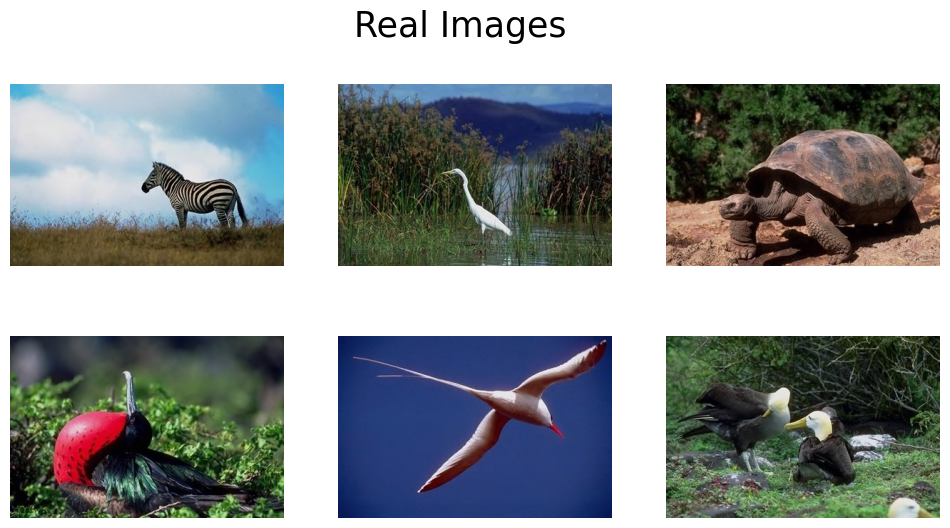

In [9]:
num_images_to_display = 6
plt.figure(figsize=(12, 6))

for i in range(num_images_to_display):
    img_path = os.path.join(real,real_path[i])
    img = Image.open(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.suptitle("Real Images",fontsize=25)
    plt.axis('off')

plt.show()

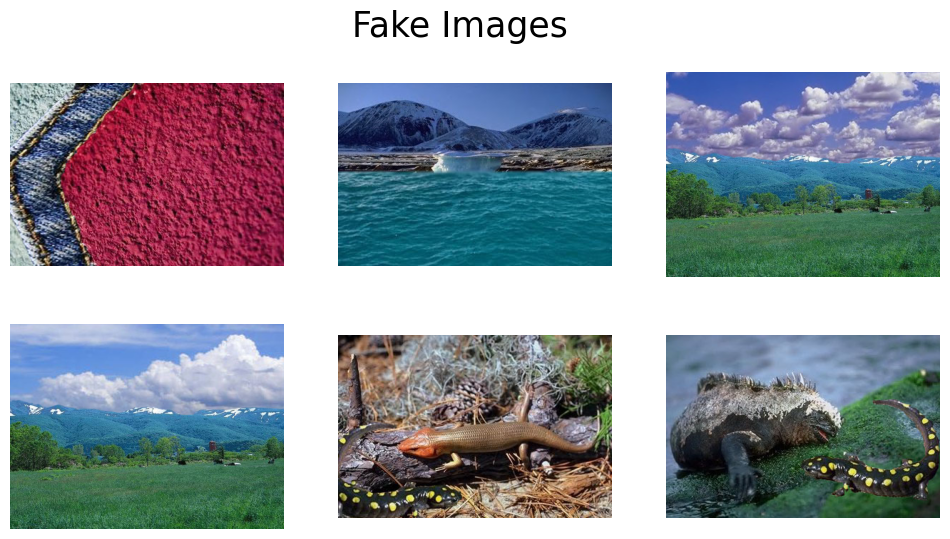

In [13]:
image_files = [file for file in fake_path if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

num_images_to_display = 6
plt.figure(figsize=(12, 6))
for i in range(num_images_to_display):
    img_path = os.path.join(fake, image_files[i])
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.suptitle("Fake Images",fontsize=25)
    plt.axis('off')

plt.show()

In [16]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

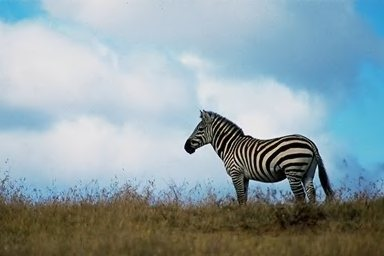

In [ ]:
real_image_path = r'/content/drive/MyDrive/dataset/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

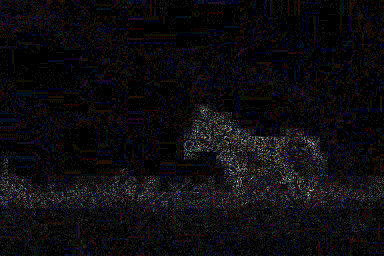

In [23]:
convert_to_ela_image(real_image_path, 90)

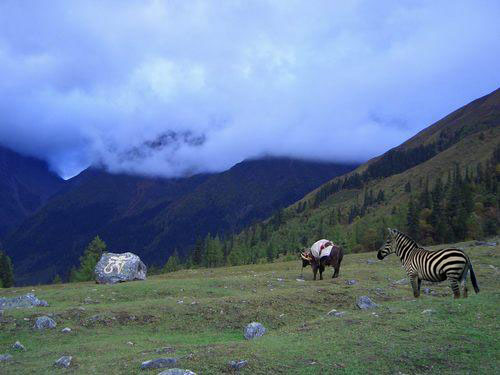

In [ ]:
fake_image_path=r"/content/drive/MyDrive/dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg"
Image.open(fake_image_path)

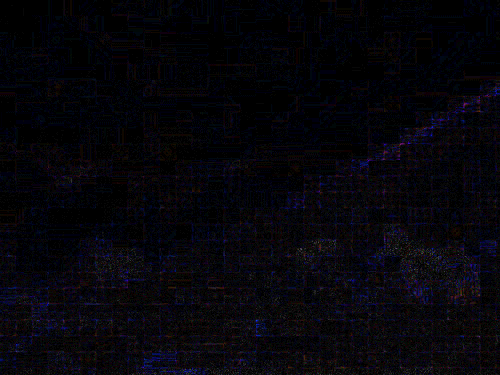

In [27]:
convert_to_ela_image(fake_image_path, 90)

In [ ]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0
X = [] # ELA converted images
Y = [] #0 for fake 1 for real

In [ ]:
import random
path = '/content/drive/MyDrive/dataset/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:1500]
Y = Y[:1500]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
1500 1500


In [ ]:
path = '/content/drive/MyDrive/dataset/CASIA2/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2000 images
2462 2462


In [6]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

#Train Test split with 80:20 ratio

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

1969 1969
493 493


In [7]:
def build_model():
    model = Sequential()
    # A sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    #transforms the 2D array into a 1D array
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [10]:
epochs = 20
batch_size = 32
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [11]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/20
62/62 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.6618

62/62 [==============================] - 204s 3s/step - loss: 0.5217 - accuracy: 0.6618 - val_loss: 0.3949 - val_accuracy: 0.8803
Epoch 2/20
62/62 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8878

62/62 [==============================] - 209s 3s/step - loss: 0.3213 - accuracy: 0.8878 - val_loss: 0.2867 - val_accuracy: 0.8966
Epoch 3/20
62/62 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.8969

62/62 [==============================] - 205s 3s/step - loss: 0.2811 - accuracy: 0.8969 - val_loss: 0.2754 - val_accuracy: 0.9047
Epoch 4/20
62/62 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.9030

62/62 [==============================] - 194s 3s/step - loss: 0.2596 - accuracy: 0.9030 - val_loss: 0.2579 - val_accuracy: 0.9006
Epoch 5/20
62/62 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9050

62/62 [==============================] - 207s 3s/step - loss: 0.2412 - accuracy: 0.9050 - val_loss: 0.2598 - val_accuracy: 0.8986
Epoch 6/20
62/62 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9192

62/62 [==============================] - 208s 3s/step - loss: 0.2218 - accuracy: 0.9192 - val_loss: 0.2381 - val_accuracy: 0.9067
Epoch 7/20
62/62 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9259

62/62 [==============================] - 192s 3s/step - loss: 0.2017 - accuracy: 0.9259 - val_loss: 0.2521 - val_accuracy: 0.9108
Epoch 8/20
62/62 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9309

62/62 [==============================] - 194s 3s/step - loss: 0.1916 - accuracy: 0.9309 - val_loss: 0.2183 - val_accuracy: 0.9209
Epoch 9/20
62/62 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9314

62/62 [==============================] - 206s 3s/step - loss: 0.1797 - accuracy: 0.9314 - val_loss: 0.2032 - val_accuracy: 0.9229
Epoch 10/20
62/62 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9421

62/62 [==============================] - 203s 3s/step - loss: 0.1631 - accuracy: 0.9421 - val_loss: 0.1982 - val_accuracy: 0.9229
Epoch 11/20
62/62 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 0.9477

62/62 [==============================] - 205s 3s/step - loss: 0.1438 - accuracy: 0.9477 - val_loss: 0.1929 - val_accuracy: 0.9270
Epoch 12/20
62/62 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9553

62/62 [==============================] - 209s 3s/step - loss: 0.1278 - accuracy: 0.9553 - val_loss: 0.3415 - val_accuracy: 0.8864
Epoch 13/20
62/62 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9553

62/62 [==============================] - 204s 3s/step - loss: 0.1239 - accuracy: 0.9553 - val_loss: 0.1847 - val_accuracy: 0.9351
Epoch 14/20
62/62 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9629

62/62 [==============================] - 194s 3s/step - loss: 0.1083 - accuracy: 0.9629 - val_loss: 0.1840 - val_accuracy: 0.9331
Epoch 15/20
62/62 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9685

62/62 [==============================] - 191s 3s/step - loss: 0.0962 - accuracy: 0.9685 - val_loss: 0.2068 - val_accuracy: 0.9168
Epoch 16/20
62/62 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9705

62/62 [==============================] - 197s 3s/step - loss: 0.0949 - accuracy: 0.9705 - val_loss: 0.1876 - val_accuracy: 0.9331
Epoch 17/20
62/62 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9746

62/62 [==============================] - 193s 3s/step - loss: 0.0864 - accuracy: 0.9746 - val_loss: 0.1885 - val_accuracy: 0.9371
Epoch 18/20
62/62 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9756

62/62 [==============================] - 202s 3s/step - loss: 0.0748 - accuracy: 0.9756 - val_loss: 0.1989 - val_accuracy: 0.9391
Epoch 19/20
62/62 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9807

62/62 [==============================] - 190s 3s/step - loss: 0.0693 - accuracy: 0.9807 - val_loss: 0.2468 - val_accuracy: 0.9209
Epoch 20/20
62/62 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9807

62/62 [==============================] - 203s 3s/step - loss: 0.0704 - accuracy: 0.9807 - val_loss: 0.1866 - val_accuracy: 0.9331


In [12]:
model.save('model_casia_run1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


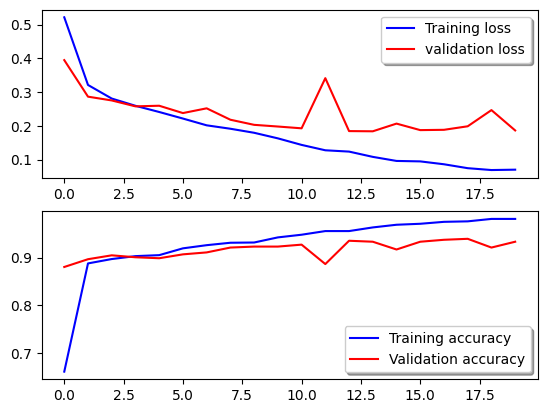

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

16/16 [==============================] - 15s 916ms/step


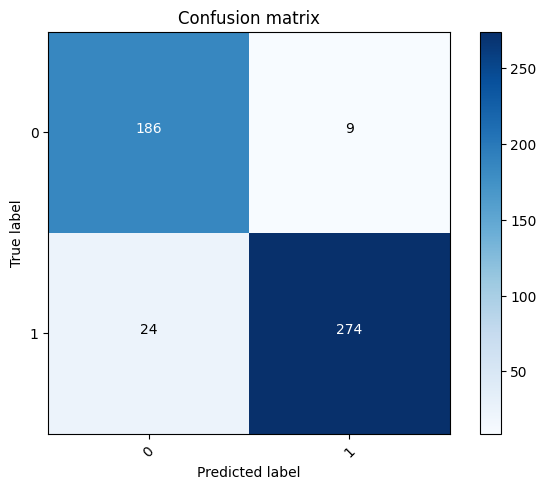

In [15]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
class_names = ['fake', 'real']
real_image_path = r'/content/drive/MyDrive/dataset/CASIA2/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

fake_image_path=r"/content/drive/MyDrive/dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg"
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 81ms/step
Class: real Confidence: 100.00
1/1 [==============================] - 0s 103ms/step
Class: fake Confidence: 99.85


In [ ]:
fake_image = os.listdir('/content/drive/MyDrive/dataset/CASIA2/Tp')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/drive/MyDrive/dataset/CASIA2/Tp', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1

1/1 [==============================] - 0s 46ms/step


In [2]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')


Total: 2662, Correct: 2653, Acc: 99.06444906444906


In [ ]:
real_image = os.listdir('/content/drive/MyDrive/dataset/CASIA2/Au')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/drive/MyDrive/dataset/CASIA2/Au', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 97ms/step


In [20]:
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')

Total: 7447, Correct: 6897, Acc: 92.61447562776958


In [3]:
correct += correct_r
total += total_r
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 10109, Correct: 9550, Acc: 93.35236056606018


In [1]:
TP = confusion_mtx[1, 1]
TN = confusion_mtx[0, 0]
FP = confusion_mtx[0, 1]
FN = confusion_mtx[1, 0]

# Calculate precision
precision = TP / float(TP + FP)

# Calculate recall
recall = TP / float(TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.976063829787234
Recall: 0.841743119266055
F1 Score: 0.9039408866995073


In [26]:
loaded_model = load_model('model_casia_run1.h5')

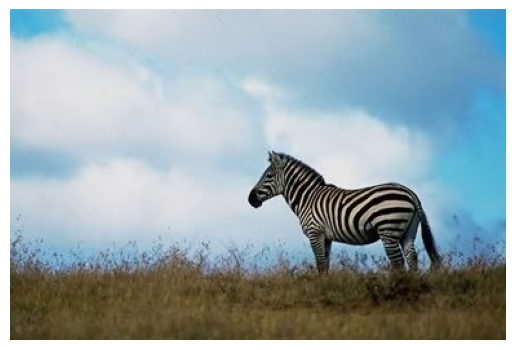

1/1 [==============================] - 0s 85ms/step
Prediction: Class: real, Confidence: 100.00%


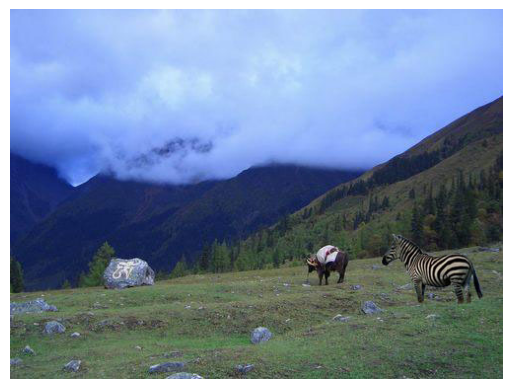

1/1 [==============================] - 0s 49ms/step
Prediction: Class: fake, Confidence: 99.85%


In [ ]:
# Function to prepare the image for prediction
def prepare_image_for_prediction(image_path):
    # Load and prepare the image
    image = prepare_image(image_path)
    image = image.reshape(-1, 128, 128, 3)
    return image

# Function to make predictions on a single image
def predict_single_image(image_path, model):
    # Prepare the image for prediction
    image = prepare_image_for_prediction(image_path)
    # Make predictions
    y_pred = model.predict(image)
    y_pred_class = np.argmax(y_pred, axis=1)[0]
    confidence = np.amax(y_pred) * 100
    return class_names[y_pred_class], confidence

# Function to display the image with prediction
def display_image_with_prediction(image_path, model):
    # Load the image
    image = Image.open(image_path)
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    # Predict the class and confidence
    image_class, confidence = predict_single_image(image_path, model)
    print(f'Prediction: Class: {image_class}, Confidence: {confidence:.2f}%')

# Example usage:
real_image_path = r'/content/drive/MyDrive/dataset/CASIA2/Au/Au_ani_00001.jpg'
fake_image_path=r"/content/drive/MyDrive/dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg"

# Display real image with prediction
display_image_with_prediction(real_image_path, model)

# Display fake image with prediction
display_image_with_prediction(fake_image_path, model)
